# 프로젝트 2 : 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?
- 목표
    - RMSE 값 150 이하를 달성
    - 시각화 요구사항이 정확하게 이루어졌는가?

## Library, data 불러오기

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [39]:
train = pd.read_csv("~/data/data/bike-sharing-demand/train.csv").drop(columns=['casual', 'registered'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 850.6+ KB


In [40]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


## 변수 설명

- **`datetime`**: 시간별 날짜 + 타임스탬프
- **`season`**: 계절
    - 1: 봄 (spring)
    - 2: 여름 (summer)
    - 3: 가을 (fall)
    - 4: 겨울 (winter)
- **`holiday`**: 공휴일 여부 (1: 공휴일, 0: 아님)
- **`workingday`**: 근무일 여부 (주말이나 공휴일이 아니면 1)
- **`weather`**: 날씨
    - 1: 맑음, 약간 구름, 부분적 구름
    - 2: 안개 + 흐림, 안개 + 흩어진 구름, 안개
    - 3: 가벼운 눈/비, 천둥 번개
    - 4: 폭우, 폭설, 우박
- **`temp`**: 섭씨 온도
- **`atemp`**: 섭씨 체감 온도
- **`humidity`**: 상대 습도
- **`windspeed`**: 풍속
- **`casual`**: 비회원 대여 수 (제거함) (물론 회원 대비 비회원이 대여한 비율과 같은 변수를 만들어도 되지만.. 그냥 제거함)
- **`registered`**: 회원 대여 수 (제거함) (그런 비율로 만들어야 target에 직접적인 연관이 아닌 변수가 생성되기에)
- **`count`**: **총 대여 수 (Target)**

## 날짜 데이터 분리하기

In [41]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
 10  year        10886 non-null  int32         
 11  month       10886 non-null  int32         
 12  day         10886 non-null  int32         
 13  hour        10886 non-null  int32         
 14  minute      10886 non-null  int32         
 15  second      10886 non-null  int32         
dtypes: datetime64[ns](1), 

# 시각화 EDA

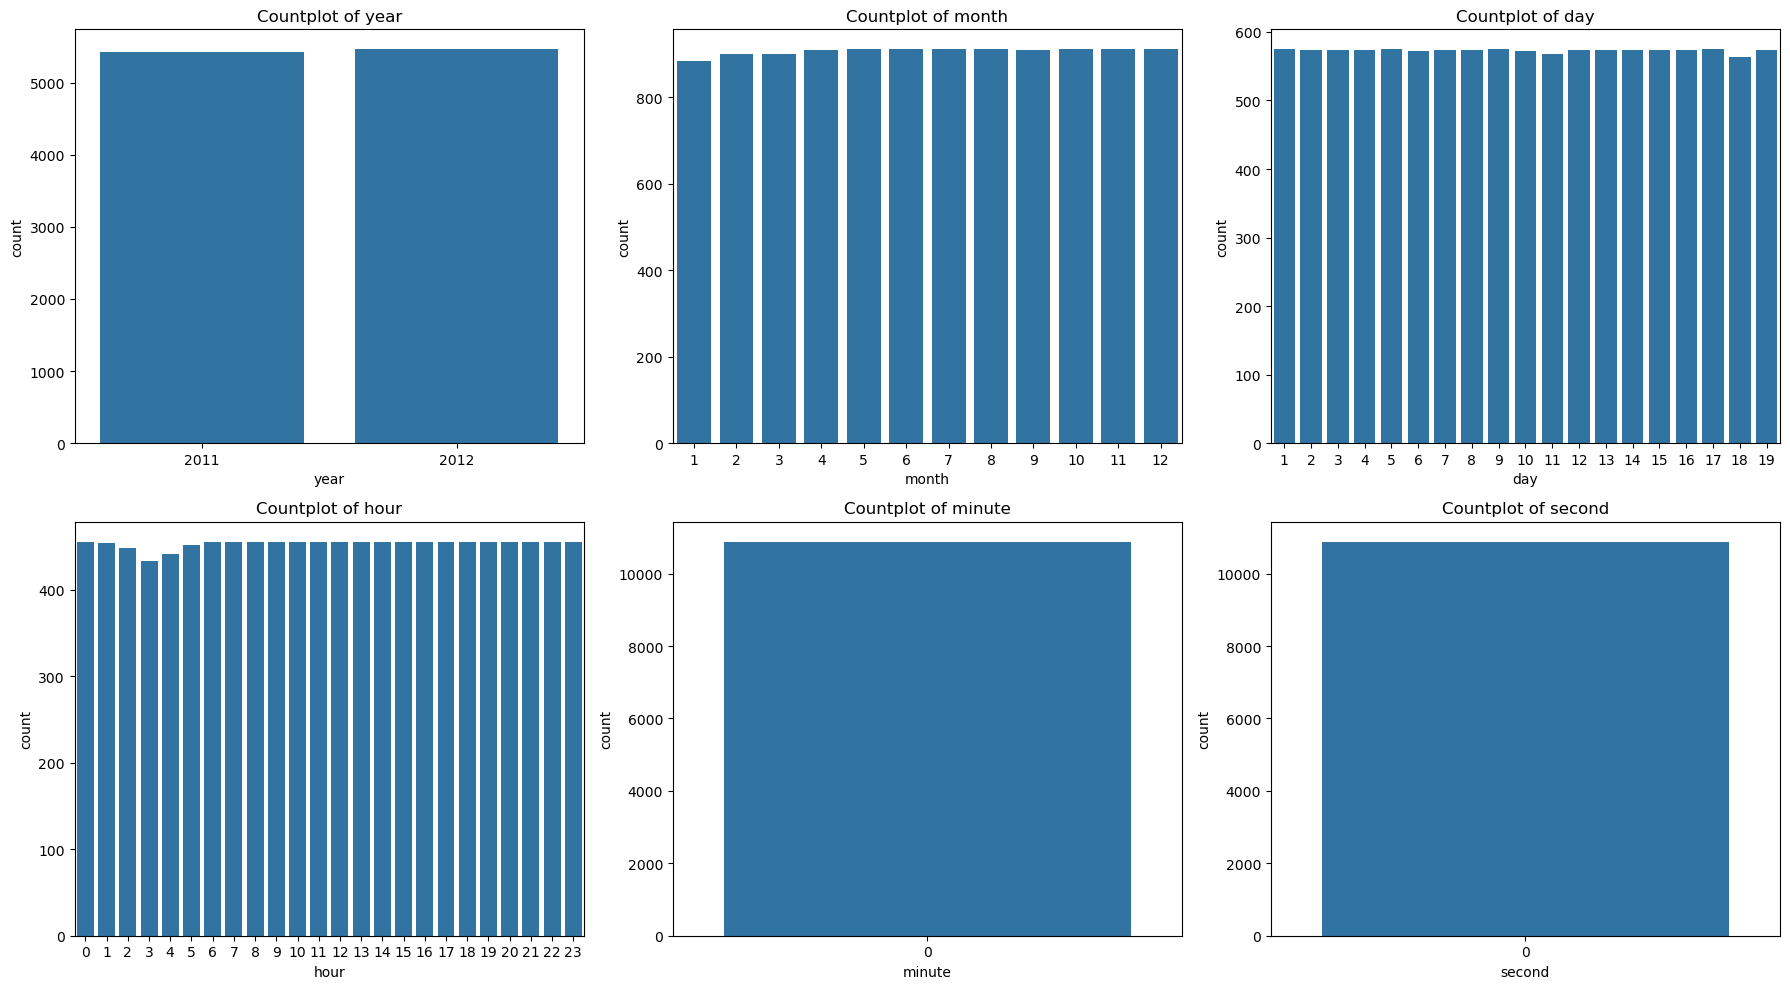

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
cols = ['year', 'month', 'day', 'hour', 'minute', 'second']
for ax, col in zip(axs.flatten(), cols):
    sns.countplot(x=col, data=train, ax=ax)
    ax.set_title(f'Countplot of {col}')
plt.tight_layout()
plt.show()

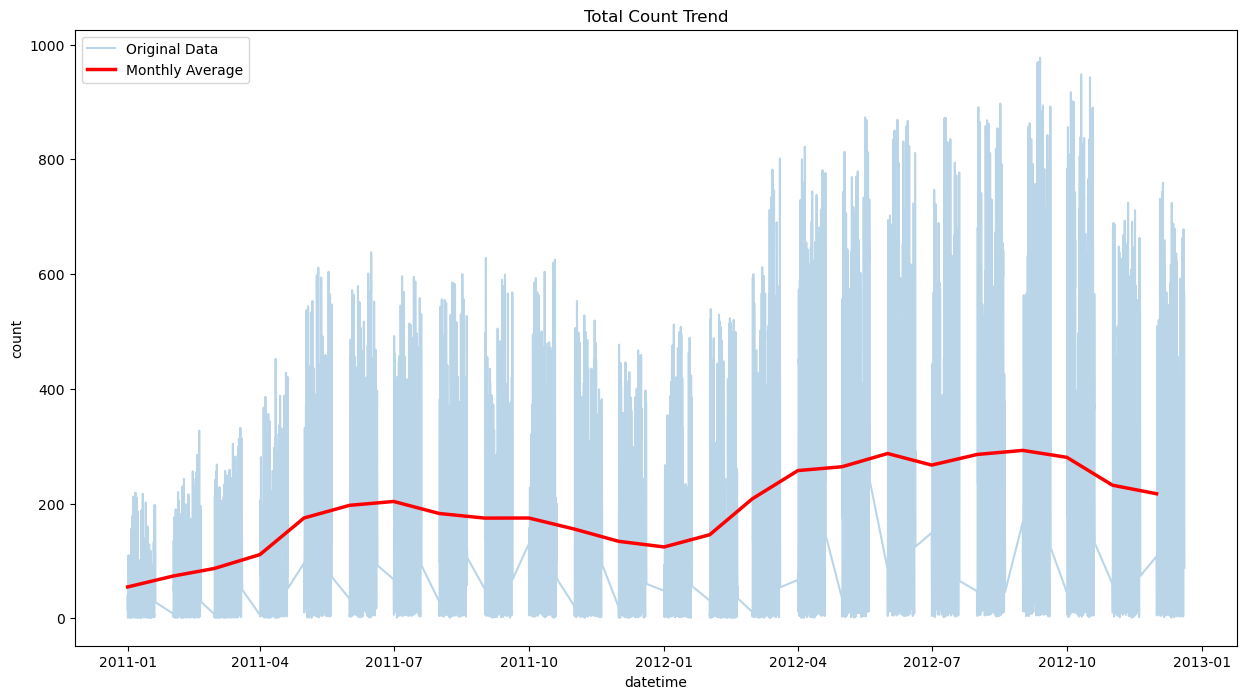

In [57]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x='datetime', y='count', data=train, ax=ax, label='Original Data', alpha=0.3)


monthly_agg = train.groupby(['year', 'month'])['count'].mean().reset_index()
monthly_agg['year_month'] = monthly_agg['year'].astype(str) + '-' + monthly_agg['month'].astype(str).str.zfill(2)
monthly_agg['datetime'] = pd.to_datetime(monthly_agg['year_month'])

sns.lineplot(x='datetime', y='count', data=monthly_agg, ax=ax, color='red', label='Monthly Average', linewidth=2.5)

ax.set_title('Total Count Trend')
ax.legend()

plt.show()

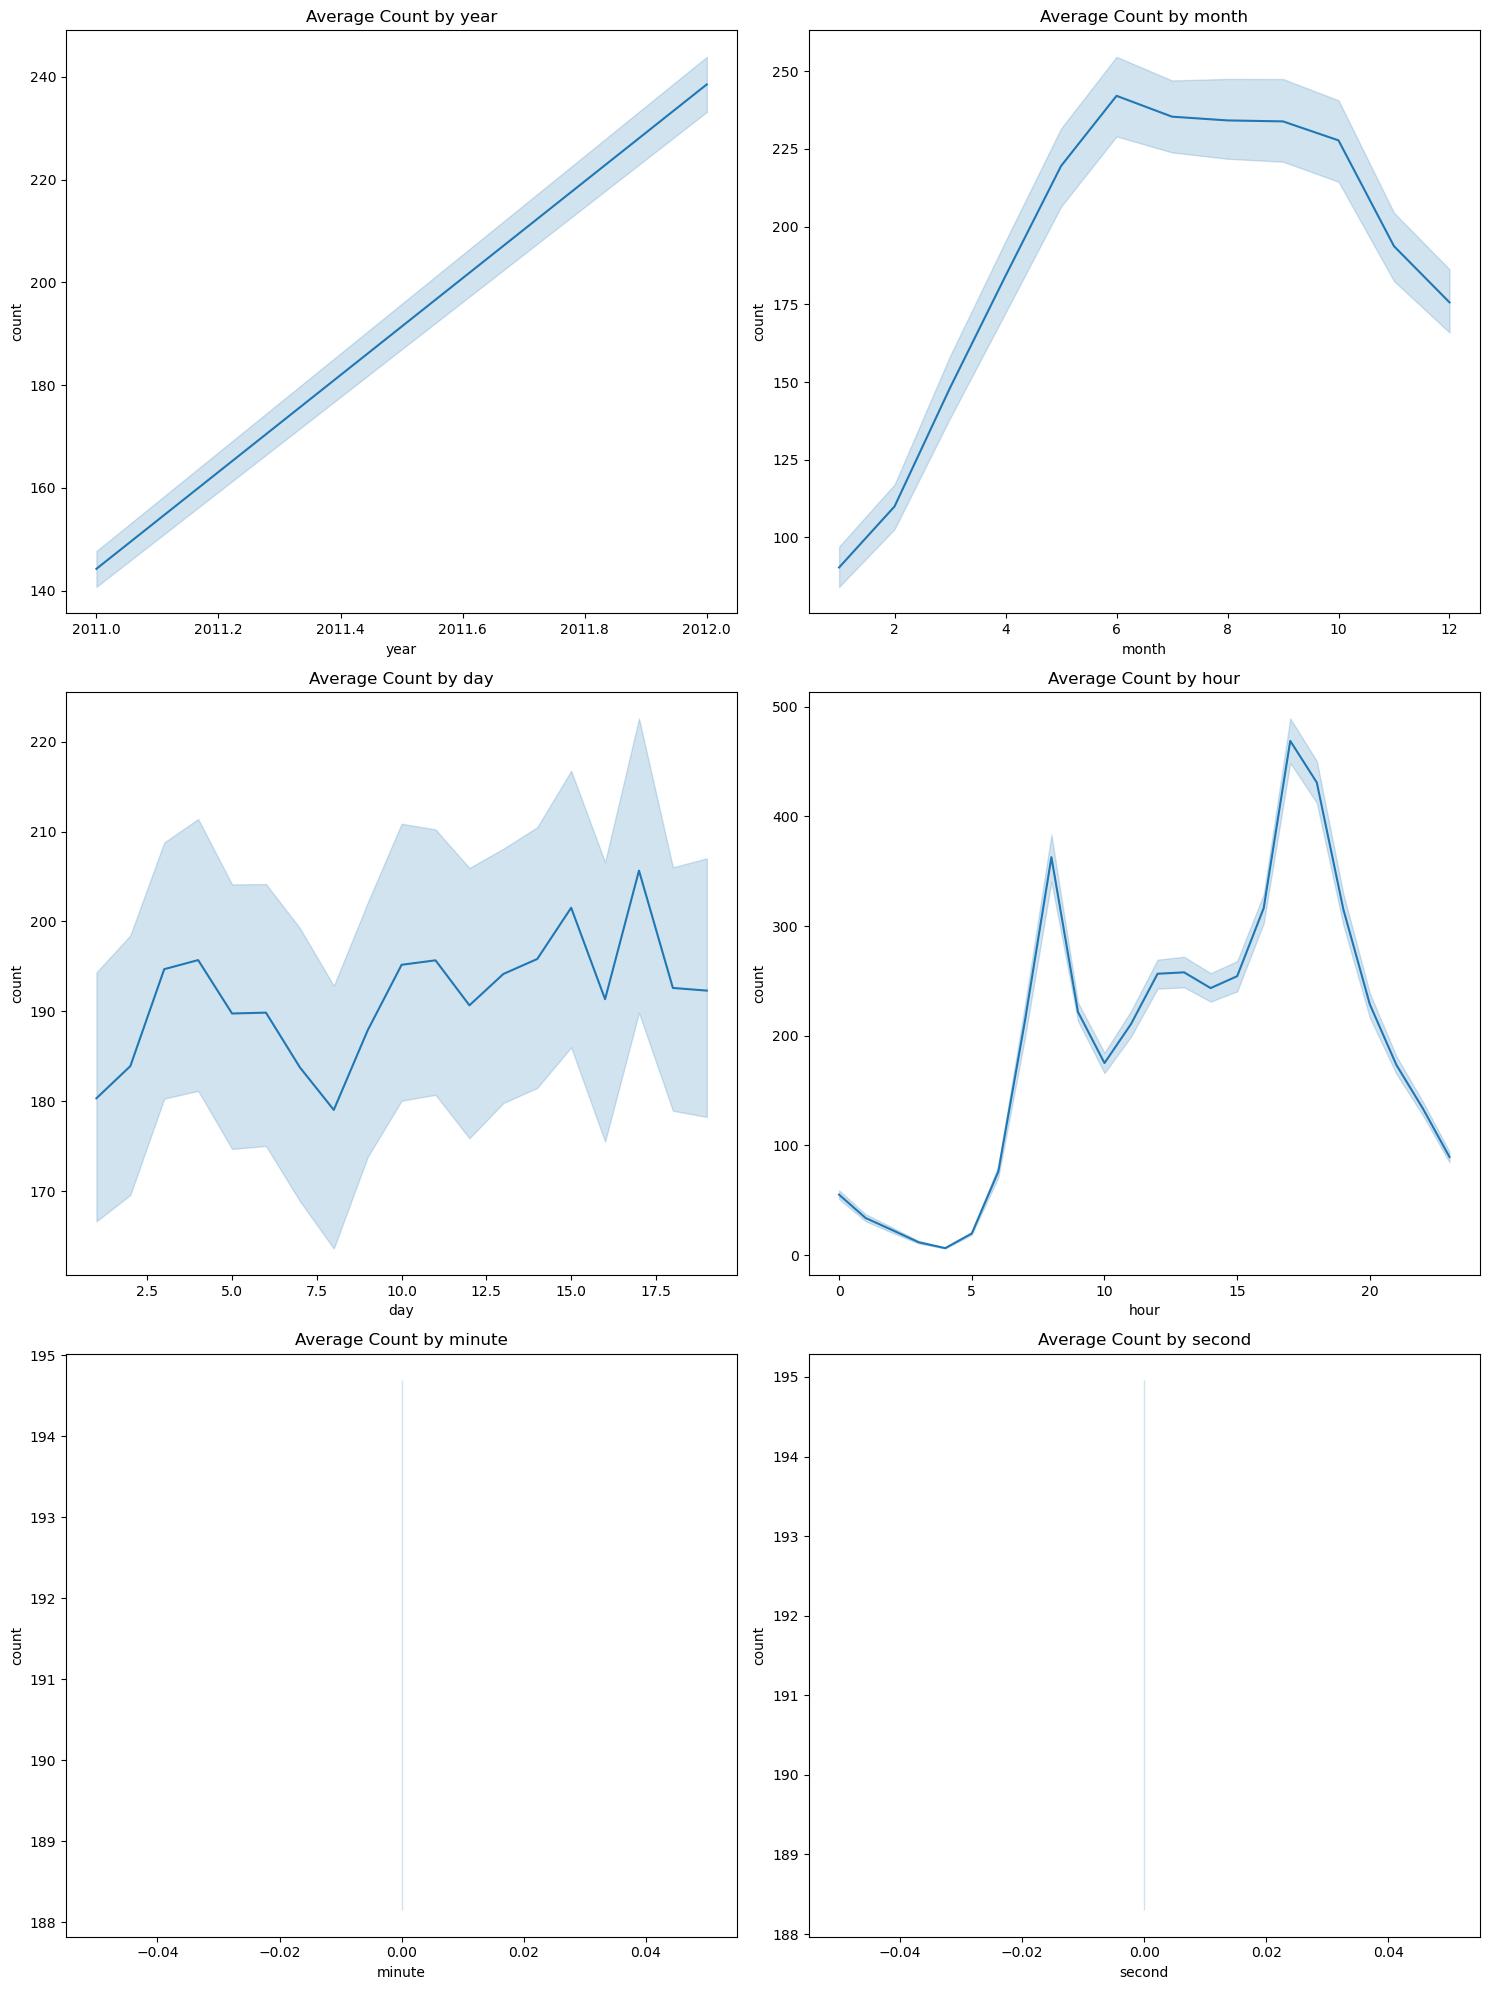

In [55]:
time_features = ['year', 'month', 'day', 'hour', 'minute', 'second']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
axes = axes.flatten()

for i, feature in enumerate(time_features):
    sns.lineplot(x=feature, y='count', data=train, ax=axes[i])
    axes[i].set_title(f'Average Count by {feature}')

plt.tight_layout()
plt.show()

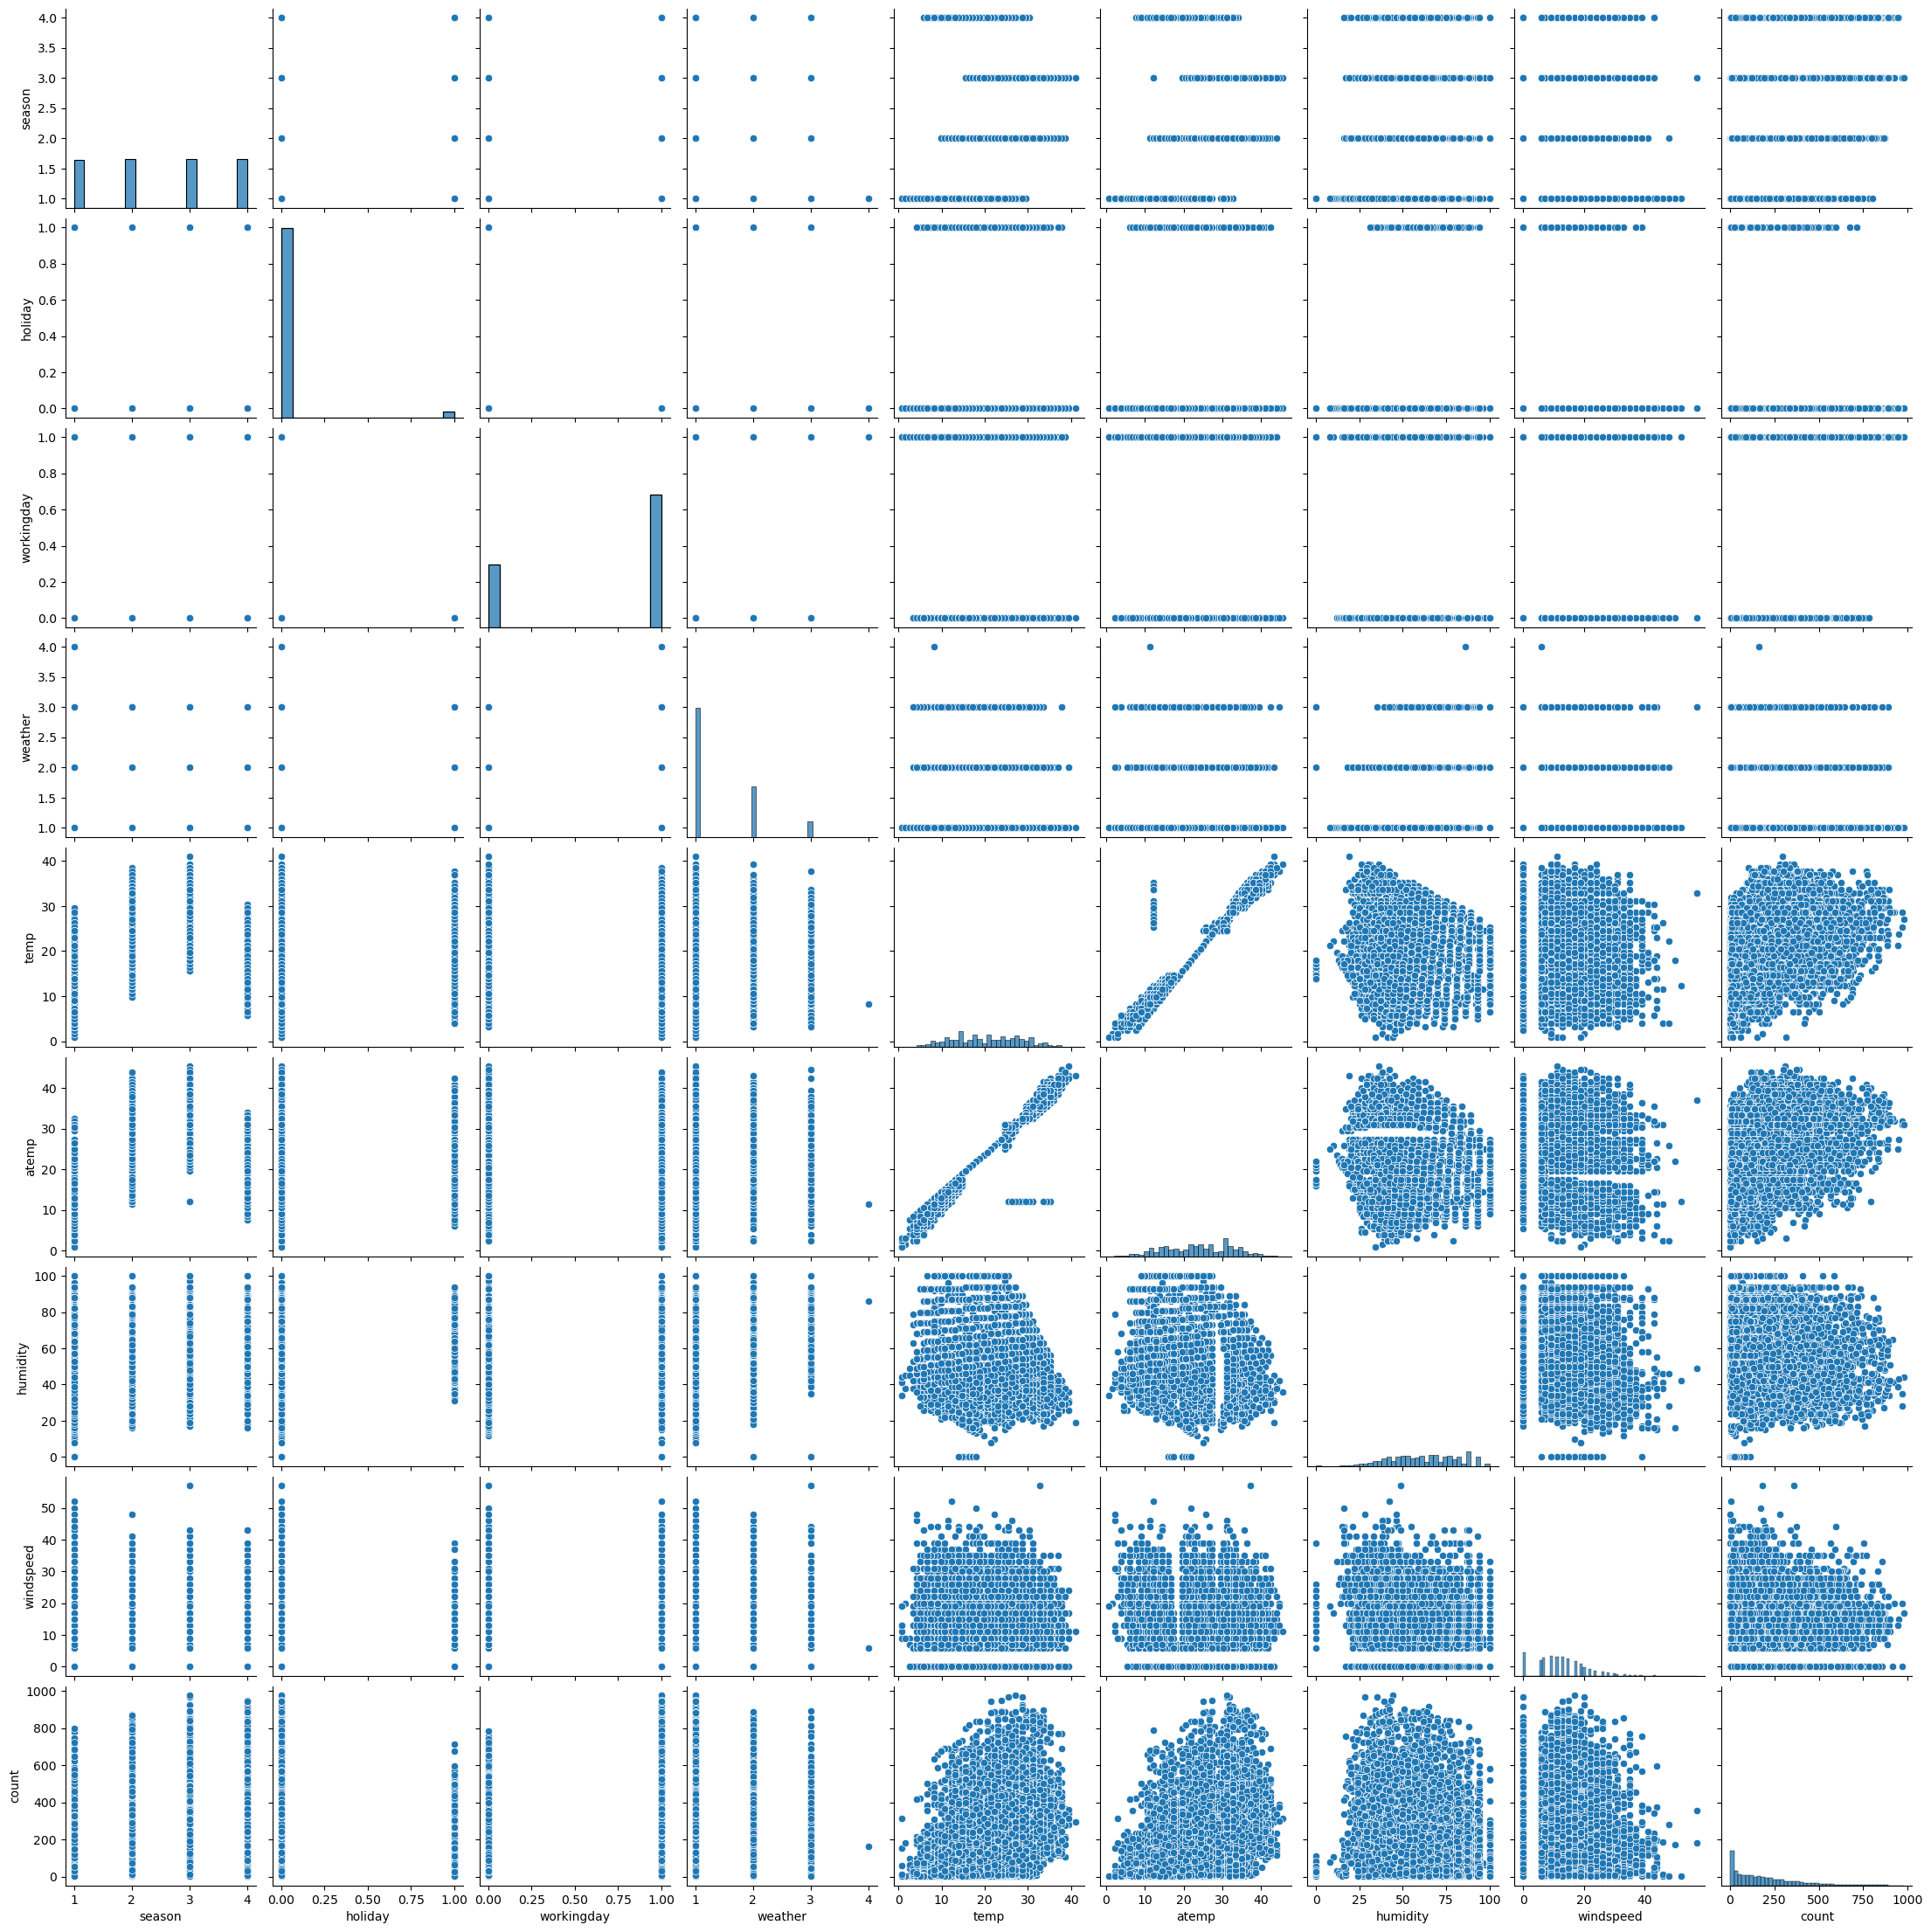

In [43]:
sns.pairplot(data=train.drop(columns=['datetime','year', 'month', 'day', 'hour', 'minute', 'second']))

<Axes: >

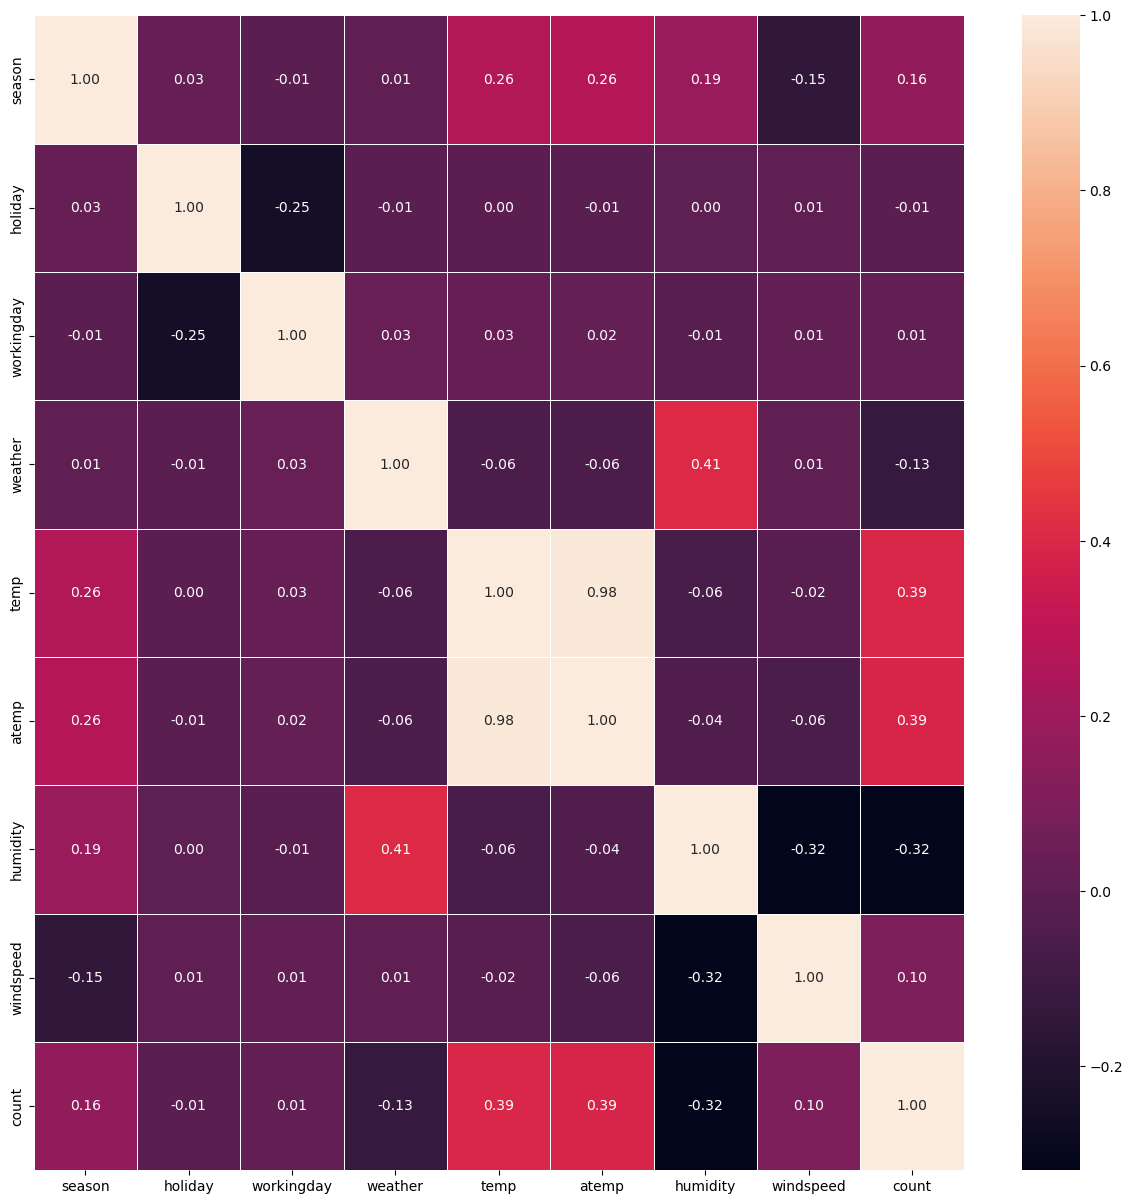

In [44]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.drop(columns=['datetime','year', 'month', 'day', 'hour', 'minute', 'second']).corr(), annot=True, fmt = '.2f', linewidths=.5)

In [27]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'minute', 'second'],
      dtype='object')

## 모델

In [58]:
features = ['year', 'month', 'day', 'hour', 'temp', 'humidity', 'windspeed']
X = train[features]
y = train['count']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [59]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [60]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 19961.901814435438
RMSE: 141.2865946027274


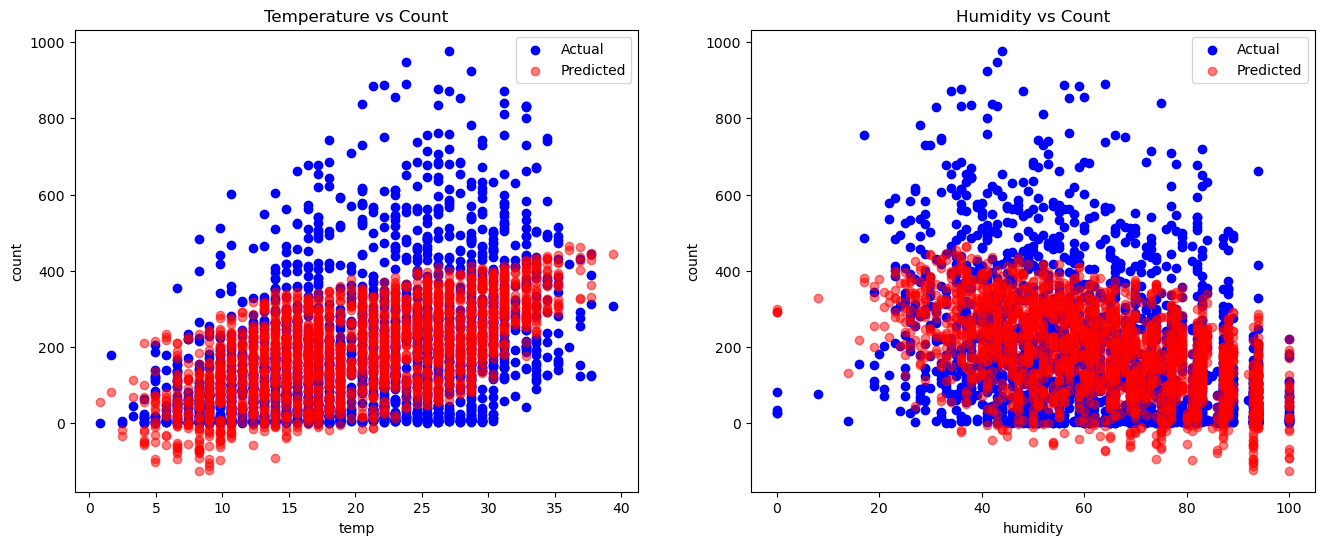

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# temp vs count 시각화
axs[0].scatter(X_test['temp'], y_test, color='blue', label='Actual')
axs[0].scatter(X_test['temp'], y_pred, color='red', label='Predicted', alpha=0.5)
axs[0].set_xlabel('temp')
axs[0].set_ylabel('count')
axs[0].set_title('Temperature vs Count')
axs[0].legend()

# humidity vs count 시각화
axs[1].scatter(X_test['humidity'], y_test, color='blue', label='Actual')
axs[1].scatter(X_test['humidity'], y_pred, color='red', label='Predicted', alpha=0.5)
axs[1].set_xlabel('humidity')
axs[1].set_ylabel('count')
axs[1].set_title('Humidity vs Count')
axs[1].legend()